# CONSTANT  TEMP

Text(392.71486928104576, 0.5, 'P(bar)')

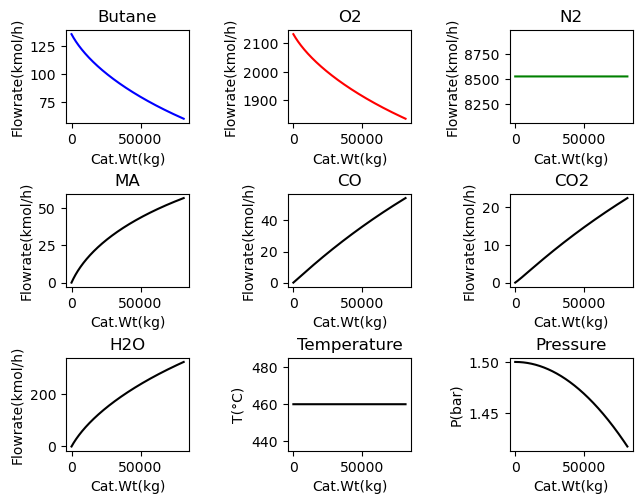

In [12]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
# R2  C4H2O3 + 2O2 -> 2CO + 2CO2 + H2O  
# R3  C4H10 +  5O2 -> 3CO + 1CO2 + 5H2O   
def dF(F,W):
    FBut, FO2, FN2, FMA, FCO, FCO2, FH2O, T, P = F
   #But/O2/MA/CO/CO2/H2O
    R  = 8.314
    k1_0 = 1.24/1000000   #kmol/(kgCat*s* atm^0.54 )
    k2_0 = 0.15/100000   #kmol/(kg cat.*s* atm^-1)
    k3_0 = 0.15/1000000   #kmol/(kg cat.*s* atm^-0.54)
    alpha1 = 0.54
    alpha3 = 0.54
    K2 = 310
    E1 = 93100   #kj/kmol
    E2 = 155000  #kj/kmol
    E3 = 93100   #kj/kmol
    k1 = k1_0*np.exp(E1/R/673 - E1/R/T) 
    k2 = k2_0*np.exp(E2/R/673 - E2/R/T)
    k3 = k3_0*np.exp(E3/R/673 - E3/R/T)
    F_all = (FBut+FO2+FN2+FMA+FCO+FCO2+FH2O)
    
    ###Pressure###
    # P1 = FBut/F_all
    # P2 = FO2/F_all
    P_But = FBut/F_all*P
    P_O2 = FO2/F_all*P
    P_MA = FMA/F_all*P
    P_CO = FCO/F_all*P
    P_CO2 = FCO2/F_all*P
    P_H2O = FH2O/F_all*P
    P_N2 = FN2/F_all*P
    ###Rate###
    Rate1 = k1*(P_But**alpha1) / (1+K2*P_MA)*1.01325
    Rate2 = k2*P_MA / ((1+K2*P_MA)**2)*1.01325
    Rate3 = (k3)*(P_But**alpha3)*1.01325
    
    ###Cp###  cal/mol ref from aspen
    CpMA = (39+16*((1459/T)/np.sinh(1459/T))**2-6*((8/T)/np.cosh(8/T))**2) *1000
    CpH2O = (8+6*((2610/T)/np.sinh(2610/T))**2+2*((1169/T)/np.cosh(1169/T))**2) *1000
    CpBut = (19 + 39*((841/T)/np.sinh(841/T))**2 + 25*((2476/T)/np.cosh(2476/T))**2) *1000
    CpCO2 = (7 + 8*((1428/T)/np.sinh(1428/T))**2 + 6*((588/T)/np.cosh(588/T))**2) *1000
    CpCO = (6+2*(3085/T/np.sinh(3085/T))**2+2*(1538/T/np.sinh(1538/T))**2) *1000
    CpO2 = (6+2*(2526/T/np.sinh(2526/T))**2+2*(1153/T/np.sinh(1153/T))**2) *1000
    
    ###heat of formation ### kcal/kmol
    H_But = -127.1 *1000  #Nist
    H_MA = -470.71 *1000 #Nist
    H_CO2 = -393.5 *1000 #Nist
    H_CO = -110.5 *1000  #Nist
    H_O2 = 0
    H_H2O = -241.8 *1000  #Nist
    HRX1 = (H_MA + 4*H_H2O - 3.5*H_O2 - H_But )  
    # R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
    HRX2 = (2*H_CO +2*H_CO +H_H2O -2*H_O2 - H_MA ) 
    # R2  C4H2O3 + 2O2 -> 2CO + 2CO2 + H2O  
    HRX3 = (3*H_CO +H_CO2 +5*H_H2O -5*H_O2 - H_But )
    # R3  C4H10 +  5O2 -> 3CO + 1CO2 + 5H2O  


    d_But   = -(Rate1 + Rate3)*3600 #But kmol/hr
    d_O2  = -(3.5*Rate1 + 2*Rate2 + 5*Rate3)*3600 #O2
    d_MA  = (Rate1 - Rate2)*3600 #MA
    d_CO   = (2*Rate2 + 3* Rate3)*3600 #CO
    d_CO2   = (2*Rate2 + 1*Rate3)*3600 #CO2
    d_H2O   = (4*Rate1 + 1*Rate2 + 5*Rate3)*3600 #H2O
    d_N2  = 0
    d_T  = 0
#     d_T=-(( (Rate1)*(-1*(HRX1+(CpMA+ 4*CpH2O- 3.5*CpO2 -CpBut )*(T)))+
#         (Rate2)*(-1*(HRX2+(2*CpCO+ 2*CpCO2+ CpH2O- 2*CpO2- CpMA)*(T))) +
#         (Rate3)*(-1*(HRX3+(3*CpCO+ 1*CpCO2+ 5*CpH2O- 5*CpO2- CpBut)*(T))))
#         /(FBut*CpBut+FO2*CpO2)) * 3600
    d_p = 0.0508 # particle diameter (m)
    epsilon = 0.44 # bed porosity
    rho_p = 2900 # particle density (kg/m^3)
    mu = 34.3/1000000 # fluid viscosity (Pa s)
    u = 10 # superficial velocity (m/s)
    A_p = np.pi * d_p**2 / 4 # particle cross-sectional area (m^2)
    S = (1 - epsilon) / epsilon # shape factor
    rho_b = rho_p * (1 - epsilon) # bulk density (kg/m^3)
    Re = rho_b * d_p * u / mu # Reynolds number
    G = rho_b * u # mass velocity (kg/m^2/s)
    f = (150 * mu) / ((d_p**2) * epsilon**3) + 1.75 * (1 - epsilon) / (Re**0.5 * epsilon**3)

    d_P = -(f * (150 * mu * (4*W/(np.pi*d_p**2 *rho_p*(1-epsilon))) / (d_p**2)) * (d_p * epsilon**3 * A_p**2)-(1.75 * d_p * epsilon**3 * A_p) * (mu * d_p) / ((4*W/(np.pi*d_p**2 *rho_p*(1-epsilon)) * Re**0.5)))
    return [d_But, d_O2, d_N2, d_MA, d_CO, d_CO2, d_H2O, d_T, d_P/10000]
   
Wspan = np.linspace(1, 81185, 1000000)
F0   = [136, 2132, 8528, 0, 0, 0, 0, 733.15, 1.5] #kmol/hr
Fsol1  = odeint(dF,F0,Wspan)

fig, axs = plt.subplots(3,3)
fig.tight_layout(h_pad=3,w_pad =4)
axs[0,0].plot(Wspan,Fsol1[:,0],'b')
axs[0,0].set_title('Butane')
axs[0,1].plot(Wspan,Fsol1[:,1],'r')
axs[0,1].set_title('O2')
axs[0,2].plot(Wspan,Fsol1[:,2],'g')
axs[0,2].set_title('N2')
axs[1,0].plot(Wspan,Fsol1[:,3],'k')
axs[1,0].set_title('MA')
axs[1,1].plot(Wspan,Fsol1[:,4],'k')
axs[1,1].set_title('CO')
axs[1,2].plot(Wspan,Fsol1[:,5],'k')
axs[1,2].set_title('CO2')
axs[2,0].plot(Wspan,Fsol1[:,6],'k')
axs[2,0].set_title('H2O')
axs[2,1].plot(Wspan,Fsol1[:,7]-273.15,'k')
axs[2,1].set_title('Temperature')
axs[2,2].plot(Wspan,Fsol1[:,8],'k')
axs[2,2].set_title('Pressure')
for ax in axs.flat:
    ax.set(xlabel='Cat.Wt(kg)',ylabel='Flowrate(kmol/h)')
axs[2, 1].set_ylabel('T(°C)')
axs[2, 2].set_ylabel('P(bar)')

# plt.show()
# np.set_printoptions(precision=1, suppress = True)
# print("========= Profile of Packed Bed Reactor Output ========")
# print(f'         ==BUTANE = {round(Fsol1[999][0])} ',f'O2 = {round(Fsol1[999][1]) }',f'N2 = {round(Fsol1[999][2])}==')
# print(f'          ==MA = {round(Fsol1[999][3])} ',f'CO = {round(Fsol1[999][4])} ',f'CO2 = {round(Fsol1[999][5])}==')
# print(f'           ==H2O = {round(Fsol1[999][6])} ',f'T = {round(Fsol1[999][7]-273)} ',f'P = {(Fsol1[999][8]):.1f}==')

# ADIABATIC

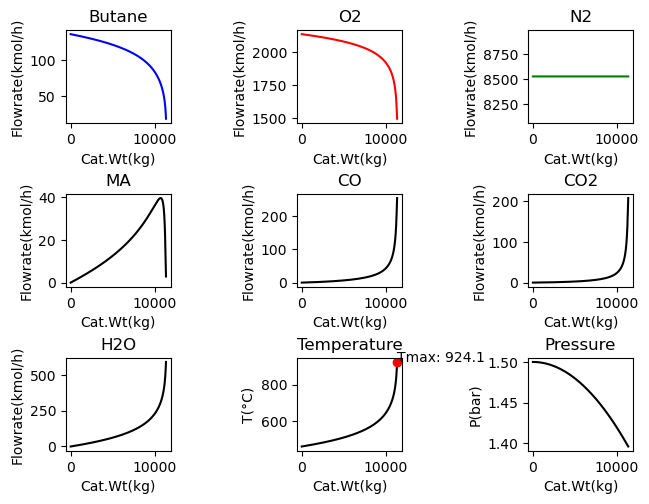

In [7]:
# change Dt , Temp is corrext but the curve is bad

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
# R2  C4H2O3 + 2O2 -> 2CO + 2CO2 + H2O  
# R3  C4H10 +  5O2 -> 3CO + 1CO2 + 5H2O   
def dF(F,W):
    FBut, FO2, FN2, FMA, FCO, FCO2, FH2O, T, P,q = F
   #But/O2/MA/CO/CO2/H2O
    R  = 8.314
    k1_0 = 1.24/1000000   #kmol/(kgCat*s* atm^0.54 )
    k2_0 = 0.15/100000   #kmol/(kg cat.*s* atm^-1)
    k3_0 = 0.15/1000000   #kmol/(kg cat.*s* atm^-0.54)
    alpha1 = 0.54
    alpha3 = 0.54
    K2 = 310
    E1 = 93100   #kj/kmol
    E2 = 155000  #kj/kmol
    E3 = 93100   #kj/kmol
    k1 = k1_0*np.exp(E1/R/673 - E1/R/T) 
    k2 = k2_0*np.exp(E2/R/673 - E2/R/T)
    k3 = k3_0*np.exp(E3/R/673 - E3/R/T)
    F_all = (FBut+FO2+FN2+FMA+FCO+FCO2+FH2O)
    
    ###Pressure###
    # P1 = FBut/F_all
    # P2 = FO2/F_all
    P_But = FBut/F_all*P
    P_O2 = FO2/F_all*P
    P_MA = FMA/F_all*P
    P_CO = FCO/F_all*P
    P_CO2 = FCO2/F_all*P
    P_H2O = FH2O/F_all*P
    P_N2 = FN2/F_all*P
    ###Rate###
    Rate1 = k1*(P_But**alpha1) / (1+K2*P_MA)*1.01325
    Rate2 = k2*P_MA / ((1+K2*P_MA)**2)*1.01325
    Rate3 = (k3)*(P_But**alpha3)*1.01325
    
    ###Cp###  kcal/kmol*k ref from aspen
    CpMA = (39+16*((1459/T)/np.sinh(1459/T))**2-6*((8/T)/np.cosh(8/T))**2) *1000 
    CpH2O = (8+6*((2610/T)/np.sinh(2610/T))**2+2*((1169/T)/np.cosh(1169/T))**2) *1000 
    CpBut = (19 + 39*((841/T)/np.sinh(841/T))**2 + 25*((2476/T)/np.cosh(2476/T))**2) *1000
    CpCO2 = (7 + 8*((1428/T)/np.sinh(1428/T))**2 + 6*((588/T)/np.cosh(588/T))**2) *1000 
    CpCO = (6+2*(3085/T/np.sinh(3085/T))**2+2*(1538/T/np.sinh(1538/T))**2) *1000 
    CpO2 = (6+2*(2526/T/np.sinh(2526/T))**2+2*(1153/T/np.sinh(1153/T))**2) *1000 
    CpN2 = 7450 
    ###heat of formation ### kj/kmol
    H_But = -127.8*1000  #Nist
    H_MA = -398.2 *1000 #Nist
    H_CO2 = -393.5 *1000 #Nist
    H_CO = -110.5 *1000 #Nist
    H_O2 = 0
    H_H2O = -241.8 *1000  #Nist
    HRX1 = (H_MA + 4*H_H2O - 3.5*H_O2 - H_But )  
    # R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
    HRX2 = (4*H_CO +H_H2O -1*H_O2 - H_MA ) 
    # R2  C4H2O3 + O2 -> 4CO  + H2O  
    HRX3 = (2*H_CO +2*H_CO2 +5*H_H2O -5.5*H_O2 - H_But )
    # R3  C4H10 +  5.5O2 -> 2CO + 2CO2 + 5H2O  


    d_But   = -(Rate1 + Rate3)*3600 #But kmol/hr
    d_O2  = -(3.5*Rate1 + 2*Rate2 + 5*Rate3)*3600 #O2
    d_MA  = (Rate1 - Rate2)*3600 #MA
    d_CO   = (2*Rate2 + 3* Rate3)*3600 #CO
    d_CO2   = (2*Rate2 + 1*Rate3)*3600 #CO2
    d_H2O   = (4*Rate1 + 1*Rate2 + 5*Rate3)*3600 #H2O
    d_N2  = 0
    d_T=-(( (Rate1*HRX1+Rate2*HRX2+Rate3*HRX3)*50/(FBut*CpBut+ FO2*CpO2+ FN2*CpN2+ FMA*CpMA+ FCO*CpCO+ FCO2*CpCO2+ FH2O*CpH2O))) *3600 *4.182  #3600s*4.182J
#     -(d_CO*CpCO+d_CO2*CpCO2+d_H2O*CpH2O+d_O2*CpO2+d_But*CpBut+d_MA*CpMA)*(T)))
    d_p = 0.0508 # particle diameter (m)
    epsilon = 0.44 # bed porosity
    rho_p = 2900 # particle density (kg/m^3)
    mu = 34.3/1000000 # fluid viscosity (Pa s)
    u = 10 # superficial velocity (m/s)
    A_p = np.pi * d_p**2 / 4 # particle cross-sectional area (m^2)
    S = (1 - epsilon) / epsilon # shape factor
    rho_b = rho_p * (1 - epsilon) # bulk density (kg/m^3)
    Re = rho_b * d_p * u / mu # Reynolds number
    G = rho_b * u # mass velocity (kg/m^2/s)
    f = (150 * mu) / ((d_p**2) * epsilon**3) + 1.75 * (1 - epsilon) / (Re**0.5 * epsilon**3)
    d_q = (d_But* CpBut + d_O2 * CpO2 + d_MA  *CpMA + d_CO  * CpCO+ d_CO2  *CpCO2 + d_H2O  *CpH2O)*d_T
    d_P = -8*(f * (150 * mu * (32*W/(np.pi*d_p**2 *rho_p*(1-epsilon))) / (d_p**2)) * (d_p * epsilon**3 * A_p**2)-(1.75 * d_p * epsilon**3 * A_p) * (mu * d_p) / ((32*W/(np.pi*d_p**2 *rho_p*(1-epsilon)) * Re**0.5)))
    return [d_But, d_O2, d_N2, d_MA, d_CO, d_CO2, d_H2O, d_T, d_P/10000, d_q]
    
Wspan = np.linspace(1, 11355, 1000000)
F0   = [136, 2132, 8528, 0, 0, 0, 0, 733.15, 1.5,0] #kmol/hr
# Fsol2  = odeint(dF,F0,Wspan,atol=1e-6, rtol=1e-6)
Fsol2,info  = odeint(dF,F0,Wspan,rtol = 1e-9 ,atol = 1e-100,full_output = 1)

fig, axs = plt.subplots(3,3)
fig.tight_layout(h_pad=3,w_pad =6)
axs[0,0].plot(Wspan,Fsol2[:,0],'b')
axs[0,0].set_title('Butane')
axs[0,1].plot(Wspan,Fsol2[:,1],'r')
axs[0,1].set_title('O2')
axs[0,2].plot(Wspan,Fsol2[:,2],'g')
axs[0,2].set_title('N2')
axs[1,0].plot(Wspan,Fsol2[:,3],'k')
axs[1,0].set_title('MA')
axs[1,1].plot(Wspan,Fsol2[:,4],'k')
axs[1,1].set_title('CO')
axs[1,2].plot(Wspan,Fsol2[:,5],'k')
axs[1,2].set_title('CO2')
axs[2,0].plot(Wspan,Fsol2[:,6],'k')
axs[2,0].set_title('H2O')


axs[2,1].plot(Wspan,Fsol2[:,7]-273.15,'k')
axs[2,1].set_title('Temperature')
max_idx = np.argmax(Fsol2[:,7])
max_val = Fsol2[:,7][max_idx] -273.15
axs[2,1].annotate(f'Tmax: {max_val:.1f}', xy=(Wspan[max_idx], max_val), xytext=(Wspan[max_idx], max_val))
axs[2,1].plot(Wspan[max_idx], max_val, 'ro')

axs[2,2].plot(Wspan,Fsol2[:,8],'k')
axs[2,2].set_title('Pressure')
# axs[0,3].plot(Wspan,Fsol[:,9],'b')
# axs[0,3].set_title('Q')

for ax in axs.flat:
    ax.set(xlabel='Cat.Wt(kg)',ylabel='Flowrate(kmol/h)')
axs[2, 1].set_ylabel('T(°C)')
axs[2, 2].set_ylabel('P(bar)')

plt.show()
np.set_printoptions(precision=1, suppress = True)
# print("========= Profile of Packed Bed Reactor Output ========")
# print(f'         ==BUTANE = {round(Fsol2[999][0])} ',f'O2 = {round(Fsol2[999][1]) }',f'N2 = {round(Fsol2[999][2])}==')
# print(f'          ==MA = {round(Fsol2[999][3])} ',f'CO = {round(Fsol2[999][4])} ',f'CO2 = {round(Fsol2[999][5])}==')
# print(f'           ==H2O = {round(Fsol2[999][6])} ',f'T = {round(Fsol2[999][7]-273)} ',f'P = {(Fsol2[999][8]):.2f}','Q==')

C:\Users\USER\AppData\Local\Temp\ipykernel_7756\3149509296.py:39: RuntimeWarning: invalid value encountered in double_scalars
  Rate1 = k1*(P_But**alpha1) / (1+K2*P_MA)*1.01325
C:\Users\USER\AppData\Local\Temp\ipykernel_7756\3149509296.py:41: RuntimeWarning: invalid value encountered in double_scalars
  Rate3 = (k3)*(P_But**alpha3)*1.01325


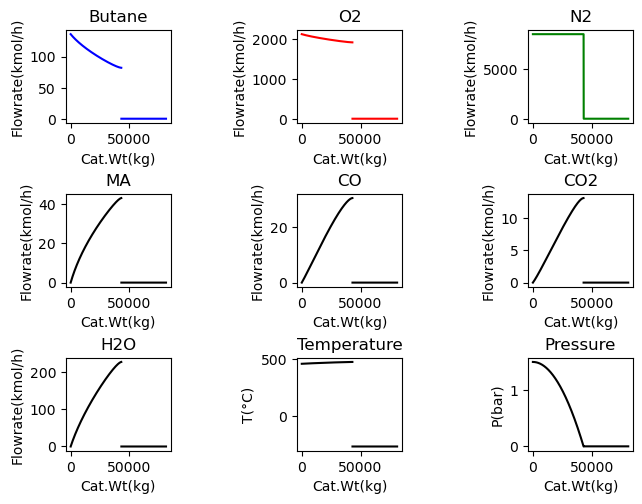

In [30]:
# change Dt , Temp is correct but the curve is bad

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
# R2  C4H2O3 + 2O2 -> 2CO + 2CO2 + H2O  
# R3  C4H10 +  5O2 -> 3CO + 1CO2 + 5H2O   
def dF(F,W):
    FBut, FO2, FN2, FMA, FCO, FCO2, FH2O, T, P,q = F
   #But/O2/MA/CO/CO2/H2O
    R  = 8.314
    k1_0 = 1.24/1000000   #kmol/(kgCat*s* atm^0.54 )
    k2_0 = 0.15/100000   #kmol/(kg cat.*s* atm^-1)
    k3_0 = 0.15/1000000   #kmol/(kg cat.*s* atm^-0.54)
    alpha1 = 0.54
    alpha3 = 0.54
    K2 = 310
    E1 = 93100   #kj/kmol
    E2 = 155000  #kj/kmol
    E3 = 93100   #kj/kmol
    k1 = k1_0*np.exp(E1/R/673 - E1/R/T) 
    k2 = k2_0*np.exp(E2/R/673 - E2/R/T)
    k3 = k3_0*np.exp(E3/R/673 - E3/R/T)
    F_all = (FBut+FO2+FN2+FMA+FCO+FCO2+FH2O)
    
    ###Pressure###
    # P1 = FBut/F_all
    # P2 = FO2/F_all
    P_But = FBut/F_all*P
    P_O2 = FO2/F_all*P
    P_MA = FMA/F_all*P
    P_CO = FCO/F_all*P
    P_CO2 = FCO2/F_all*P
    P_H2O = FH2O/F_all*P
    P_N2 = FN2/F_all*P
    ###Rate###
    Rate1 = k1*(P_But**alpha1) / (1+K2*P_MA)*1.01325
    Rate2 = k2*P_MA / ((1+K2*P_MA)**2)*1.01325
    Rate3 = (k3)*(P_But**alpha3)*1.01325
    
    ###Cp###  kcal/kmol*k ref from aspen
    CpMA = (39+16*((1459/T)/np.sinh(1459/T))**2-6*((8/T)/np.cosh(8/T))**2) *1000 
    CpH2O = (8+6*((2610/T)/np.sinh(2610/T))**2+2*((1169/T)/np.cosh(1169/T))**2) *1000 
    CpBut = (19 + 39*((841/T)/np.sinh(841/T))**2 + 25*((2476/T)/np.cosh(2476/T))**2) *1000
    CpCO2 = (7 + 8*((1428/T)/np.sinh(1428/T))**2 + 6*((588/T)/np.cosh(588/T))**2) *1000 
    CpCO = (6+2*(3085/T/np.sinh(3085/T))**2+2*(1538/T/np.sinh(1538/T))**2) *1000 
    CpO2 = (6+2*(2526/T/np.sinh(2526/T))**2+2*(1153/T/np.sinh(1153/T))**2) *1000 
    CpN2 = 7450 
    ###heat of formation ### kj/kmol
    H_But = -127.8*1000  #Nist
    H_MA = -398.2 *1000 #Nist
    H_CO2 = -393.5 *1000 #Nist
    H_CO = -110.5 *1000 #Nist
    H_O2 = 0
    H_H2O = -241.8 *1000  #Nist
    HRX1 = (H_MA + 4*H_H2O - 3.5*H_O2 - H_But )  
    # R1  C4H10 + 3.5 O2 -> C4H2O3 + 4 H2O
    HRX2 = (4*H_CO +H_H2O -1*H_O2 - H_MA ) 
    # R2  C4H2O3 + O2 -> 4CO  + H2O  
    HRX3 = (2*H_CO +2*H_CO2 +5*H_H2O -5.5*H_O2 - H_But )
    # R3  C4H10 +  5.5O2 -> 2CO + 2CO2 + 5H2O  


    d_But   = -(Rate1 + Rate3)*3600 #But kmol/hr
    d_O2  = -(3.5*Rate1 + 2*Rate2 + 5*Rate3)*3600 #O2
    d_MA  = (Rate1 - Rate2)*3600 #MA
    d_CO   = (2*Rate2 + 3* Rate3)*3600 #CO
    d_CO2   = (2*Rate2 + 1*Rate3)*3600 #CO2
    d_H2O   = (4*Rate1 + 1*Rate2 + 5*Rate3)*3600 #H2O
    d_N2  = 0
    d_T=-(Rate1*HRX1 +Rate2*HRX2 +Rate3*HRX3)/(FBut*CpBut+FO2*CpO2) *3600 *4.182  #3600s*4.182J
#     -(d_CO*CpCO+d_CO2*CpCO2+d_H2O*CpH2O+d_O2*CpO2+d_But*CpBut+d_MA*CpMA)*(T)))
    d_p = 0.0508 # particle diameter (m)
    epsilon = 0.44 # bed porosity
    rho_p = 2900 # particle density (kg/m^3)
    mu = 34.3/1000000 # fluid viscosity (Pa s)
    u = 10 # superficial velocity (m/s)
    A_p = np.pi * d_p**2 / 4 # particle cross-sectional area (m^2)
    S = (1 - epsilon) / epsilon # shape factor
    rho_b = rho_p * (1 - epsilon) # bulk density (kg/m^3)
    Re = rho_b * d_p * u / mu # Reynolds number
    G = rho_b * u # mass velocity (kg/m^2/s)
    f = (150 * mu) / ((d_p**2) * epsilon**3) + 1.75 * (1 - epsilon) / (Re**0.5 * epsilon**3)
    d_q = (d_But* CpBut + d_O2 * CpO2 + d_MA  *CpMA + d_CO  * CpCO+ d_CO2  *CpCO2 + d_H2O  *CpH2O)*d_T
    d_P = -8*(f * (150 * mu * (32*W/(np.pi*d_p**2 *rho_p*(1-epsilon))) / (d_p**2)) * (d_p * epsilon**3 * A_p**2)-(1.75 * d_p * epsilon**3 * A_p) * (mu * d_p) / ((32*W/(np.pi*d_p**2 *rho_p*(1-epsilon)) * Re**0.5)))
    return [d_But, d_O2, d_N2, d_MA, d_CO, d_CO2, d_H2O, d_T, d_P/10000, d_q]
    
Wspan = np.linspace(1, 81155, 100000)
F0   = [136, 2132, 8528, 0, 0, 0, 0, 733.15, 1.5,0] #kmol/hr
# Fsol2  = odeint(dF,F0,Wspan,atol=1e-6, rtol=1e-6)
Fsol2,info  = odeint(dF,F0,Wspan,rtol = 1e-6 ,atol = 1e-100,full_output = 1)

fig, axs = plt.subplots(3,3)
fig.tight_layout(h_pad=3,w_pad =6)
axs[0,0].plot(Wspan,Fsol2[:,0],'b')
axs[0,0].set_title('Butane')
axs[0,1].plot(Wspan,Fsol2[:,1],'r')
axs[0,1].set_title('O2')
axs[0,2].plot(Wspan,Fsol2[:,2],'g')
axs[0,2].set_title('N2')
axs[1,0].plot(Wspan,Fsol2[:,3],'k')
axs[1,0].set_title('MA')
axs[1,1].plot(Wspan,Fsol2[:,4],'k')
axs[1,1].set_title('CO')
axs[1,2].plot(Wspan,Fsol2[:,5],'k')
axs[1,2].set_title('CO2')
axs[2,0].plot(Wspan,Fsol2[:,6],'k')
axs[2,0].set_title('H2O')


axs[2,1].plot(Wspan,Fsol2[:,7]-273.15,'k')
axs[2,1].set_title('Temperature')
max_idx = np.argmax(Fsol2[:,7])
max_val = Fsol2[:,7][max_idx] -273.15
axs[2,1].annotate(f'Tmax: {max_val:.1f}', xy=(Wspan[max_idx], max_val), xytext=(Wspan[max_idx], max_val))
axs[2,1].plot(Wspan[max_idx], max_val, 'ro')

axs[2,2].plot(Wspan,Fsol2[:,8],'k')
axs[2,2].set_title('Pressure')
# axs[0,3].plot(Wspan,Fsol[:,9],'b')
# axs[0,3].set_title('Q')

for ax in axs.flat:
    ax.set(xlabel='Cat.Wt(kg)',ylabel='Flowrate(kmol/h)')
axs[2, 1].set_ylabel('T(°C)')
axs[2, 2].set_ylabel('P(bar)')

plt.show()
np.set_printoptions(precision=1, suppress = True)
# print("========= Profile of Packed Bed Reactor Output ========")
# print(f'         ==BUTANE = {round(Fsol2[999][0])} ',f'O2 = {round(Fsol2[999][1]) }',f'N2 = {round(Fsol2[999][2])}==')
# print(f'          ==MA = {round(Fsol2[999][3])} ',f'CO = {round(Fsol2[999][4])} ',f'CO2 = {round(Fsol2[999][5])}==')
# print(f'           ==H2O = {round(Fsol2[999][6])} ',f'T = {round(Fsol2[999][7]-273)} ',f'P = {(Fsol2[999][8]):.2f}','Q==')

# COMBINE ALL THE PLOT TOGETHER

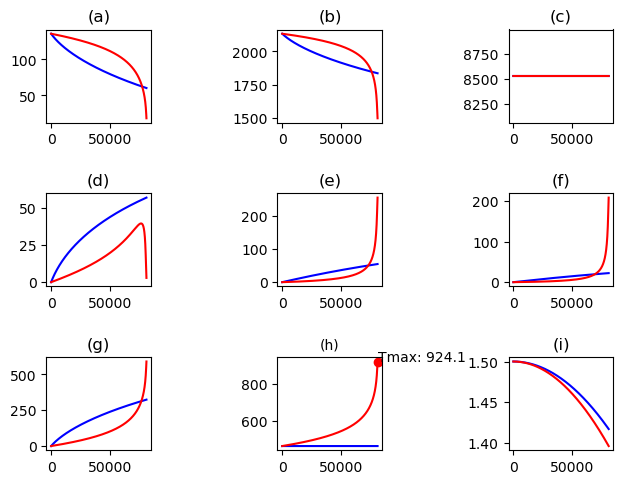

In [13]:
fig, axs = plt.subplots(3,3)
fig.tight_layout(h_pad=3,w_pad =6)
axs[0,0].plot(Wspan,Fsol1[:,0],'b')
axs[0,0].plot(Wspan,Fsol2[:,0],'r')

axs[0,0].set_title('(a)')
axs[0,1].plot(Wspan,Fsol1[:,1],'b')
axs[0,1].plot(Wspan,Fsol2[:,1],'r')

axs[0,1].set_title('(b)')
axs[0,2].plot(Wspan,Fsol1[:,2],'b')
axs[0,2].plot(Wspan,Fsol2[:,2],'r')

axs[0,2].set_title('(c)')
axs[1,0].plot(Wspan,Fsol1[:,3],'b')
axs[1,0].plot(Wspan,Fsol2[:,3],'r')

axs[1,0].set_title('(d)')
axs[1,1].plot(Wspan,Fsol1[:,4],'b')
axs[1,1].plot(Wspan,Fsol2[:,4],'r')

axs[1,1].set_title('(e)')
axs[1,2].plot(Wspan,Fsol1[:,5],'b')
axs[1,2].plot(Wspan,Fsol2[:,5],'r')

axs[1,2].set_title('(f)')
axs[2,0].plot(Wspan,Fsol1[:,6],'b')
axs[2,0].plot(Wspan,Fsol2[:,6],'r')

axs[2,0].set_title('(g)')
axs[2,1].plot(Wspan,Fsol1[:,7]-273.15,'b')
axs[2,1].plot(Wspan,Fsol2[:,7]-273.15,'r')

max_idx = np.argmax(Fsol2[:,7])
max_val = Fsol2[:,7][max_idx] -273.15
axs[2,1].annotate(f'Tmax: {max_val:.1f}', xy=(Wspan[max_idx], max_val), xytext=(Wspan[max_idx], max_val))
axs[2,1].plot(Wspan[max_idx], max_val, 'ro')
axs[2,1].set_title('(h)',fontsize=10)

axs[2,2].plot(Wspan,Fsol1[:,8],'b')
axs[2,2].plot(Wspan,Fsol2[:,8],'r')
axs[2,2].set_title('(i)')
plt.show()

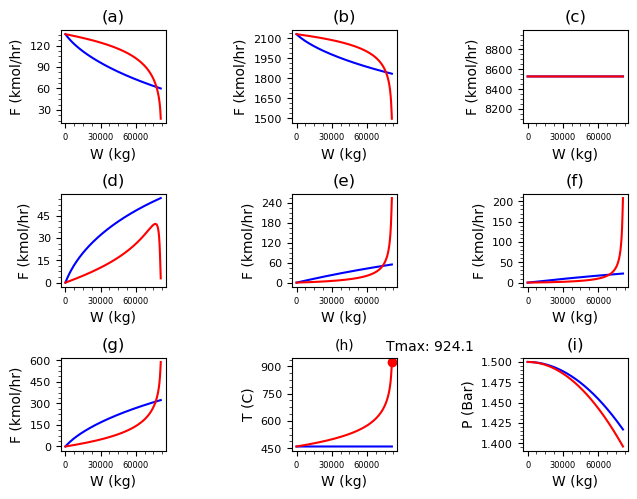

In [50]:
fig, axs = plt.subplots(3,3)
fig.tight_layout(h_pad=3,w_pad =6)

axs[0,0].plot(Wspan,Fsol1[:,0],'b')
axs[0,0].plot(Wspan,Fsol2[:,0],'r')
axs[0,0].set_title('(a)')
axs[0, 0].set_xlabel('W (kg)')
axs[0, 0].set_ylabel('F (kmol/hr)')
axs[0, 0].tick_params(axis='x', labelsize=6)
axs[0, 0].tick_params(axis='y', labelsize=8)

axs[0,1].plot(Wspan,Fsol1[:,1],'b')
axs[0,1].plot(Wspan,Fsol2[:,1],'r')
axs[0,1].set_title('(b)')
axs[0, 1].set_xlabel('W (kg)')
axs[0, 1].set_ylabel('F (kmol/hr)')
axs[0, 1].tick_params(axis='x', labelsize=6)
axs[0, 1].tick_params(axis='y', labelsize=8)

axs[0,2].plot(Wspan,Fsol1[:,2],'b')
axs[0,2].plot(Wspan,Fsol2[:,2],'r')
axs[0,2].set_title('(c)')
axs[0, 2].set_xlabel('W (kg)')
axs[0, 2].set_ylabel('F (kmol/hr)')
axs[0, 2].tick_params(axis='x', labelsize=6)
axs[0, 2].tick_params(axis='y', labelsize=8)

axs[1,0].plot(Wspan,Fsol1[:,3],'b')
axs[1,0].plot(Wspan,Fsol2[:,3],'r')
axs[1,0].set_title('(d)')
axs[1, 0].set_xlabel('W (kg)')
axs[1, 0].set_ylabel('F (kmol/hr)')
axs[1, 0].tick_params(axis='x', labelsize=6)
axs[1, 0].tick_params(axis='y', labelsize=8)

axs[1,1].plot(Wspan,Fsol1[:,4],'b')
axs[1,1].plot(Wspan,Fsol2[:,4],'r')
axs[1,1].set_title('(e)')
axs[1, 1].set_xlabel('W (kg)')
axs[1, 1].set_ylabel('F (kmol/hr)')
axs[1,1].tick_params(axis='x', labelsize=6)
axs[1,1].tick_params(axis='y', labelsize=8)

axs[1,2].plot(Wspan,Fsol1[:,5],'b')
axs[1,2].plot(Wspan,Fsol2[:,5],'r')
axs[1,2].set_title('(f)')
axs[1, 2].set_xlabel('W (kg)')
axs[1, 2].set_ylabel('F (kmol/hr)')
axs[1, 2].tick_params(axis='x', labelsize=6)
axs[1, 2].tick_params(axis='y', labelsize=8)

axs[2,0].plot(Wspan,Fsol1[:,6],'b')
axs[2,0].plot(Wspan,Fsol2[:,6],'r')
axs[2,0].set_title('(g)')
axs[2, 0].set_xlabel('W (kg)')
axs[2, 0].set_ylabel('F (kmol/hr)')
axs[2, 0].tick_params(axis='x', labelsize=6)
axs[2, 0].tick_params(axis='y', labelsize=8)

axs[2,1].plot(Wspan,Fsol1[:,7]-273.15,'b')
axs[2,1].plot(Wspan,Fsol2[:,7]-273.15,'r')
axs[2,1].set_title('(h)',fontsize=10)
axs[2, 1].set_xlabel('W (kg)')
axs[2, 1].set_ylabel('T (C)')
axs[2, 1].tick_params(axis='x', labelsize=6)
axs[2, 1].tick_params(axis='y', labelsize=8)

# Annotate maximum value of the red curve
max_idx = np.argmax(Fsol2[:,7])
max_val = Fsol2[:,7][max_idx] -273.15
axs[2,1].annotate(f'Tmax: {max_val:.1f}', xy=(Wspan[max_idx], max_val), xytext=( Wspan[max_idx]-5000, max_val+60 ))
axs[2,1].plot(Wspan[max_idx], max_val, 'ro')


axs[2,2].plot(Wspan,Fsol1[:,8],'b')
axs[2,2].plot(Wspan,Fsol2[:,8],'r')
axs[2,2].set_title('(i)')
axs[2,2].set_xlabel('W (kg)')
axs[2,2].set_ylabel('P (Bar)')
axs[2, 2].tick_params(axis='x', labelsize=6)
axs[2,2].tick_params(axis='y', labelsize=8)

# Set the number of x and y ticks
for ax in axs.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()


In [38]:
def wen_yu_pressure_drop(rho_p, rho_f, L, g=9.81):
    delta_P = L * (rho_p - rho_f) * g
    return delta_P

# 輸入參數值
rho_p = 2500  # 固體顆粒密度, kg/m³
rho_f = 1000  # 流體密度, kg/m³
L = 2.0       # 反應器高度, m

# 計算壓降
delta_P = wen_yu_pressure_drop(rho_p, rho_f, L)
print(f"壓降為：{delta_P} Pa")

壓降為：29430.0 Pa


C:\Users\USER\AppData\Local\Temp\ipykernel_33056\1589286768.py:37: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
C:\Users\USER\AppData\Local\Temp\ipykernel_33056\1589286768.py:39: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)


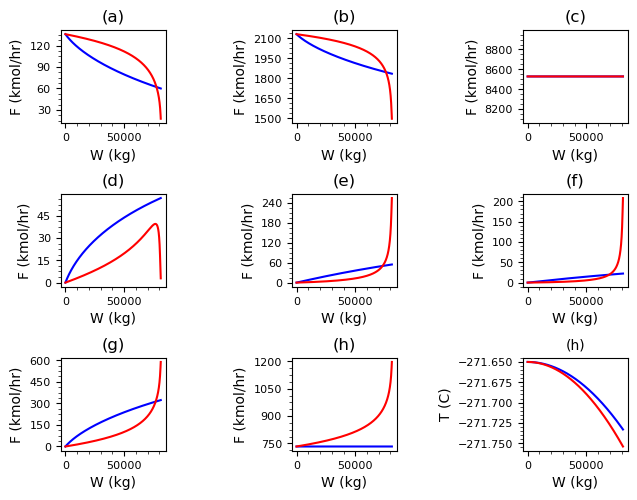

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
# Fsol1 = ...
# Fsol2 = ...
# Wspan = ...

fig, axs = plt.subplots(3, 3)
fig.tight_layout(h_pad=3, w_pad=6)

# Plot all subplots and set titles, labels, and ticks
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        if index < 8:
            axs[i, j].plot(Wspan, Fsol1[:, index], 'b')
            axs[i, j].plot(Wspan, Fsol2[:, index], 'r')
            axs[i, j].set_title(f'({chr(ord("a") + index)})')
            axs[i, j].set_xlabel('W (kg)')
            axs[i, j].set_ylabel('F (kmol/hr)')

        # Modify subplot (h) for temperature
        elif index == 8:
            axs[i, j].plot(Wspan, Fsol1[:, index] - 273.15, 'b')
            axs[i, j].plot(Wspan, Fsol2[:, index] - 273.15, 'r')
            axs[i, j].set_title('(h)', fontsize=10)
            axs[i, j].set_xlabel('W (kg)')
            axs[i, j].set_ylabel('T (C)')

        # Set the number of x and y ticks
        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(2.9))
        axs[i, j].yaxis.set_major_locator(plt.MaxNLocator(5))

        # Adjust the font size of axis tick labels
        for tick in axs[i, j].xaxis.get_major_ticks():
            tick.label.set_fontsize(8)
        for tick in axs[i, j].yaxis.get_major_ticks():
            tick.label.set_fontsize(8)

plt.show()
